<a href="https://colab.research.google.com/github/SharlotteManganye/Deep-Learning-CNN/blob/main/CIFAR_10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# torch- Our deep learning framework
import torch
import torch.nn as nn
from torchvision import datasets
import urllib.request
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from torch import optim
import torch.nn.functional as F
import math
from sklearn.model_selection import KFold
import numpy as np
import requests
import tarfile
import os
import torch.utils.data
import matplotlib.pyplot as plt

In [7]:
# Load CIFAR-10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_data = datasets.CIFAR10(
    root='data',
    train=True,
    transform=transform,
    download=True,
)

test_data = datasets.CIFAR10(
    root='data',
    train=False,
    transform=transform
)


Files already downloaded and verified


In [9]:
# DataLoaders for CIFAR-10
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=100,
    shuffle=True,
    num_workers=1
)

test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=100,
    shuffle=True,
    num_workers=1)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

**4. PI_Sigma -CNN (concatination)**

In [5]:
class PIConv2d(nn.Module):
    def __init__(self, in_channels=3, out_channels=10, kernel_size=3, stride=1):
        super(PIConv2d, self).__init__()
        self.in_channels = in_channels
        self.weights_u = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for positive inputs
        self.weights_v = nn.Parameter(torch.Tensor(out_channels, in_channels, kernel_size, kernel_size)) # for indicator function
        self.stride = stride
        # Initialize weights (important!)
        nn.init.kaiming_uniform_(self.weights_u, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weights_v, a=math.sqrt(5))

    def forward(self, x):
        batch_size, in_channels, in_height, in_width = x.size()
        kernel_size = self.weights_u.shape[2]
        out_channels = self.weights_u.shape[0]

        out_height = (in_height - kernel_size) // self.stride + 1
        out_width = (in_width - kernel_size) // self.stride + 1

        # Unfold the input tensor
        unfolded = F.unfold(x, kernel_size=kernel_size, stride=self.stride)
        unfolded = unfolded.view(batch_size, in_channels * kernel_size * kernel_size, out_height * out_width)

        # Weights for positive input component
        weights_u_reshaped = self.weights_u.view(out_channels, -1)

        # Logarithm of absolute value
        log_abs_unfolded = torch.log(torch.abs(unfolded) + 1e-10)  # Add small constant for numerical stability

        # Compute the exponential part (corresponding to Eq. 3)
        exp_term = torch.exp(torch.einsum("oc,bcp->bop", weights_u_reshaped, log_abs_unfolded))

        # Weights for indicator function
        weights_v_reshaped = self.weights_v.view(out_channels, -1)

        # Indicator function (vectorized)
        indicator = (unfolded < 0).float()

        # Compute the cosine term (corresponding to Eq. 4)
        cosine_term = torch.cos(math.pi * torch.einsum("oc,bcp->bop", weights_v_reshaped, indicator)).view(batch_size, out_channels, out_height, out_width)

        # Combine the terms
        output = exp_term.view(batch_size, out_channels, out_height, out_width) * cosine_term

        return output

In [6]:

class ConcatConv2d(nn.Module):
    def __init__(self, in_channels=3, num_classes=10):  # CIFAR-10 has 3 in_channels
        super(ConcatConv2d, self).__init__()
        self.product_conv1 = PIConv2d(in_channels, 32, kernel_size=3)
        self.conv1 = nn.Conv2d(in_channels, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3)

        self.bn1_conv = nn.BatchNorm2d(32)
        self.bn1_prod = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(128)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)

        self.kernel_size = 3
        self.pooling_size = 2

        self.fc_input_size = self._calculate_fc_input_size(32, 32)  # CIFAR-10 is 32x32

        self.fc_model = nn.Sequential(
            nn.Linear(self.fc_input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def _calculate_fc_input_size(self, image_height, image_width):
        y = torch.randn(1, self.product_conv1.in_channels, image_height, image_width)
        y = self.product_conv1(y)
        y = self.bn1_prod(y)
        y = F.tanh(y)
        y = F.max_pool2d(y, self.pooling_size)

        z = torch.randn(1, self.conv1.in_channels, image_height, image_width)
        z = self.conv1(z)
        z = self.bn1_conv(z)
        z = F.relu(z)
        z = F.max_pool2d(z, self.pooling_size)

        combined_features = torch.cat((y, z), dim=1)
        combined_features = self.conv2(combined_features)
        combined_features = self.bn2(combined_features)
        combined_features = F.relu(combined_features)
        combined_features = F.max_pool2d(combined_features, 2)

        return combined_features.view(1, -1).size(1)

    def forward(self, x, return_feature_maps=False):
        y_conv = self.product_conv1(x)
        y = self.bn1_prod(y_conv)
        y = F.tanh(y)
        y = F.max_pool2d(y, 2)

        z_conv = self.conv1(x)
        z = self.bn1_conv(z_conv)
        z = F.relu(z)
        z = F.max_pool2d(z, 2)

        if y.shape[2:] != z.shape[2:]:
            z = F.interpolate(z, size=y.shape[2:])

        combined_features = torch.cat((y, z), dim=1)
        conv2_out = self.conv2(combined_features)
        combined_features = self.bn2(conv2_out)
        combined_features = F.relu(combined_features)
        combined_features = F.max_pool2d(combined_features, 2)

        combined_features = self.dropout1(combined_features)
        combined_features = combined_features.view(combined_features.size(0), -1)

        x_fc = self.fc_model(combined_features)
        output = F.log_softmax(x_fc, dim=1)

        if return_feature_maps:
            return output, y_conv, z_conv, conv2_out
        else:
            return output

In [ ]:
print feature maps

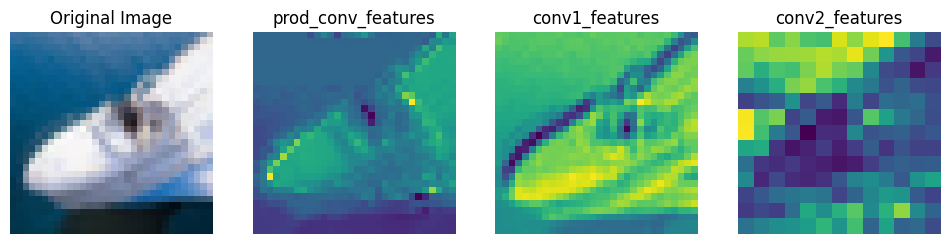

In [12]:

# Initialize model
model = ConcatConv2d()
model.eval()

# Get the first image from the dataset
data_iter = iter(train_loader)
image, label = next(data_iter)

# Get feature maps
output, prod_conv_features, conv1_features, conv2_features = model(image, return_feature_maps=True)

# Visualize the original image
plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1)
# Transpose image for matplotlib (C, H, W) -> (H, W, C)
plt.imshow(np.transpose(image[0].numpy(), (1, 2, 0)) * 0.5 + 0.5)
plt.title("Original Image")
plt.axis('off')

# Visualize prod_conv_features (show first channel as example)
plt.subplot(1, 4, 2)
plt.imshow(prod_conv_features[0][0].detach().numpy(), cmap='viridis')
plt.title("prod_conv_features")
plt.axis('off')

# Visualize conv1_features (show first channel as example)
plt.subplot(1, 4, 3)
plt.imshow(conv1_features[0][0].detach().numpy(), cmap='viridis')
plt.title("conv1_features")
plt.axis('off')

# Visualize conv2_features (show first channel as example)
plt.subplot(1, 4, 4)
plt.imshow(conv2_features[0][0].detach().numpy(), cmap='viridis')
plt.title("conv2_features")
plt.axis('off')

plt.show()

plot graphs

--- Epoch 1 ---
	Train loss: 1.3247, acc: 0.5288%
	Val loss: 1.0225, acc: 0.6399%
--- Epoch 2 ---
	Train loss: 1.0523, acc: 0.6312%
	Val loss: 0.9156, acc: 0.6838%
--- Epoch 3 ---
	Train loss: 0.9518, acc: 0.6659%
	Val loss: 0.8482, acc: 0.7068%
--- Epoch 4 ---
	Train loss: 0.8765, acc: 0.6943%
	Val loss: 0.8307, acc: 0.7114%
--- Epoch 5 ---
	Train loss: 0.8189, acc: 0.7115%
	Val loss: 0.7969, acc: 0.7268%
--- Epoch 6 ---
	Train loss: 0.7753, acc: 0.7277%
	Val loss: 0.7749, acc: 0.7320%
--- Epoch 7 ---
	Train loss: 0.7282, acc: 0.7434%
	Val loss: 0.7442, acc: 0.7455%
--- Epoch 8 ---
	Train loss: 0.6840, acc: 0.7614%
	Val loss: 0.7347, acc: 0.7455%
--- Epoch 9 ---
	Train loss: 0.6419, acc: 0.7754%
	Val loss: 0.7281, acc: 0.7486%
--- Epoch 10 ---
	Train loss: 0.5982, acc: 0.7889%
	Val loss: 0.7079, acc: 0.7583%


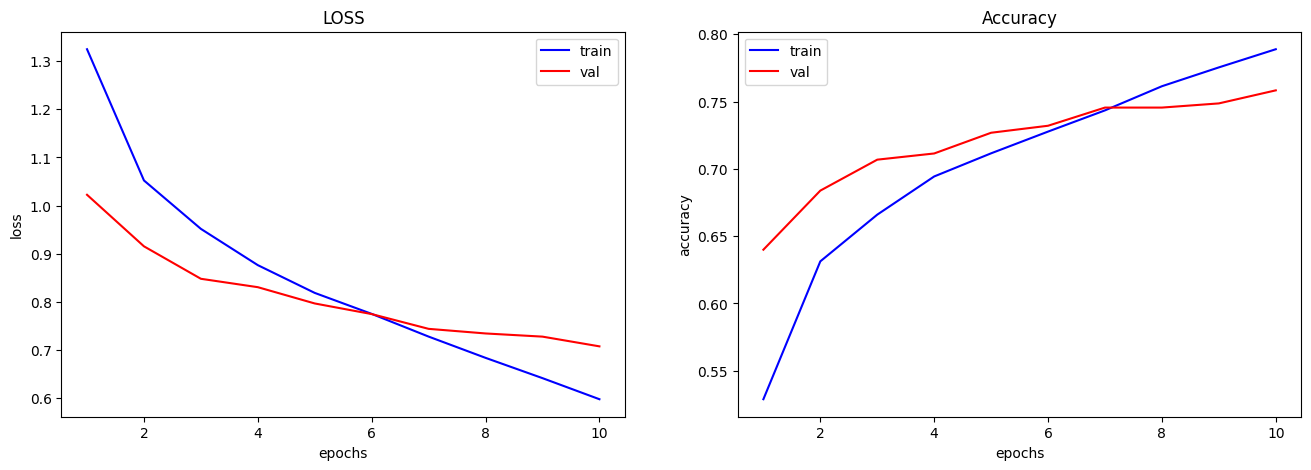

In [13]:
model = ConcatConv2d()

# loss function
loss_func = nn.CrossEntropyLoss()
# Adam optimizer
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

####TRAIN
def train(epoch):

    # Setting model in training mode.
    model.train()

    train_loss = 0
    train_acc = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        #clear gradient
        optimizer.zero_grad()

        #FP (make a prediction)
        output = model(data.float())

        # calculating the loss
        loss = loss_func(output, target)

        #BP, Computing the gradient of the loss w.r.t the parameters of the model
        loss.backward()

        # a single step of optimization, update parameters
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  #clamping
        optimizer.step()

        train_loss += loss.item()

        _, pred = output.max(1)
        train_acc += target.eq(pred).sum().item()

    train_acc /= len(train_loader.dataset)
    train_loss /= (batch_idx + 1) # Average per batch

    return train_loss, train_acc
###TEST

def val():
    # setting model in evaluation mode.
    model.eval()

    val_loss = 0
    val_acc = 0

    # no gradient is needed
    # when calling a PyTorch neural network to compute output during TRAINING, you should NEVER use the no_grad() statement,
    # but when NOT TRAINING, using the no_grad() statement is optional but more principled.
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):

            #FP
            output = model(data.float())

            # loss
            val_loss += loss_func(output, target).item()
            _, pred = output.max(1)
            val_acc += target.eq(pred).sum().item()

    val_loss /= (batch_idx + 1) # Average per batch
    val_acc /= len(test_loader.dataset)
    return val_loss, val_acc

###PLOT
loss_list = []
val_loss_list = []

acc_list = []
val_acc_list = []

epochs = 10
for epoch in range(1, epochs + 1):
    print("--- Epoch {} ---".format(epoch))

    train_loss, train_acc = train(epoch)
    print('\tTrain loss: {:.4f}, acc: {:.4f}%'.format(train_loss, train_acc))
    loss_list.append(train_loss)
    acc_list.append(train_acc)

    val_loss, val_acc =  val()
    print('\tVal loss: {:.4f}, acc: {:.4f}%'.format(val_loss, val_acc))
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
# plot


x = range(1, epochs + 1)

plt.figure(figsize=(16, 5))

#loss
plt.subplot(1,2,1)
plt.plot(x, loss_list, 'b', label = 'train')
plt.plot(x, val_loss_list, 'r', label = 'val')
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

#Accuracy
plt.subplot(1,2,2)
plt.plot(x, acc_list, 'b', label = 'train')
plt.plot(x, val_acc_list, 'r', label = 'val')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
